## Introduction

I want to test whether we can recover connections..
 - between simulated neurons
 - under 'realistic' voltage imaging conditions
 - using spike-triggered averages of subhtreshold voltages.

Here we start by simulating a single neuron excited by an incoming spike train.

## Izhikevich neuron

Model and parameters from Humphries 2006, "Understanding and using Izhikevich's simple model neuron".


Integration by forward Euler.

Parameters for a cortical regular spiking (RS) neuron.

Units are pF, mV, ms, and pA.  
(`a` is in 1/ms).

In [ ]:
C = 100; k = 0.7; v_r = -60; v_t = -40; v_peak = 35; a = 0.03; b = -2; c = -50; d = 100;

In [ ]:
T = 1000  # simulation duration
dt = 0.1  # timestep
N = round(T/dt)  # number of simulation steps

In [ ]:
import numpy as np

In [ ]:
from numba import jit

@jit
def izh_neuron(I):
    '''
    Input I and output v: arrays of length N.
    '''
    
    dv_dt = lambda v,u,i: (k*(v-v_r)*(v-v_t) - u + i)/C
    du_dt = lambda v,u: a*(b*(v-v_r) - u)

    v_t0 = v_r
    u_t0 = 0

    v = np.ones(N) * v_t0
    u = np.ones(N) * u_t0
    for i in range(N-1):
        v[i+1] = v[i] + dt * dv_dt(v[i], u[i], I[i])
        u[i+1] = u[i] + dt * du_dt(v[i], u[i])
        if v[i+1] >= v_peak:
            v[i] = v_peak
            v[i+1] = c
            u[i+1] = u[i+1] + d

    return v

Plotting function we'll reuse a few times.

In [ ]:
import matplotlib.pyplot as plt

def plot_signal(x, ylabel='', t=None):
    fig, ax = plt.subplots()
    if t is None:
        N = len(x)
        T = N*dt
        t = np.linspace(0, T, N)
    ax.plot(t, x);
    ax.set(xlabel="t (ms)", ylabel=ylabel)
    return fig, ax

Test neuron model with constant current injection.

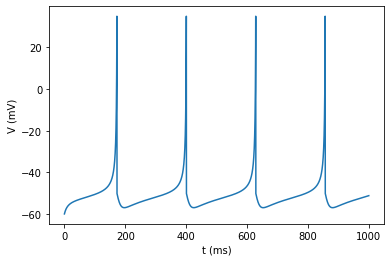

In [ ]:
v = izh_neuron(I=60*np.ones(N));
plot_signal(v, 'V (mV)');

## Presynaptic spikes

We use the same approach as in eg Dayan & Abott to generate (approximate) Poisson spike times.  
(Approximate Poisson because we ignore the possibility of a neuron spiking more than once in the same small timebin `dt`).


In [ ]:
f_spike = 1/1000  # Hz/1000

In [ ]:
from numpy.random import seed, random

seed(0)

In [ ]:
def spikes():
    spikes = np.zeros(N)
    for i in range(N):
        spikes[i] = f_spike * dt > random()
    return spikes

Aggregate spikes for all incoming neurons


In [ ]:
N_in = 20

In [ ]:
all_spikes = sum([spikes() for incoming_neuron in range(N_in)])

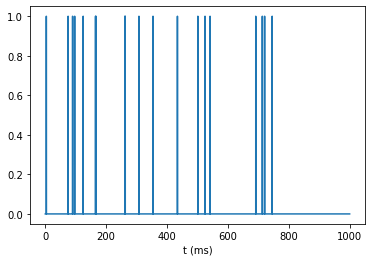

In [ ]:
plot_signal(all_spikes);

## EPSC's

Simple step-and-exponential-decay impulse response.

Parameters estimated from fig. 5.14 in Dayan & Abott.

In [ ]:
tau_EPSC = 7
height_EPSC = 290

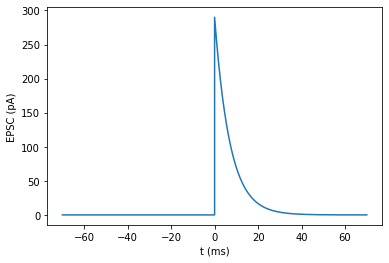

In [ ]:
T_support = 10*tau_EPSC
N_support = round(T_support/dt)
t_support = np.linspace(0, T_support, N_support)

EPSC = np.concatenate([
    np.zeros(N_support),
    np.exp(-t_support/tau_EPSC) * height_EPSC
])

plot_signal(EPSC, 'EPSC (pA)', t=np.concatenate([-t_support[::-1], t_support]));

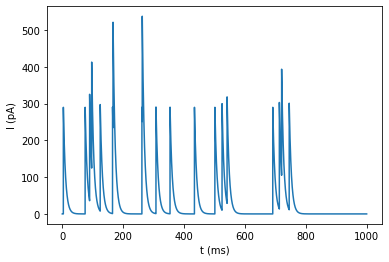

In [ ]:
I = np.convolve(all_spikes, EPSC, mode='same')
plot_signal(I, 'I (pA)');

## Apply input to neuron

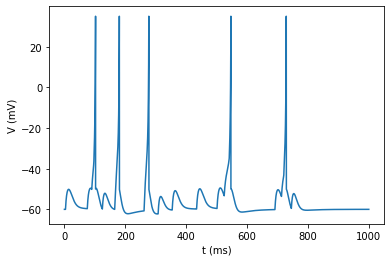

In [ ]:
v = izh_neuron(I)
plot_signal(v, 'V (mV)');

## Add voltage imaging noise

Gaussian noise, with $\sigma$ from:

$\text{SNR} = \frac{ΔV_{spike}}{\sigma_{noise}}$

(see ['Fidelity' section](https://docs.google.com/document/d/16zLBpDEG6evpBZMKQ2yFTVTzE-ZHeeD41VwHWzcmtJ8/edit#heading=h.9kehw2hr8h67) from VI lit review).

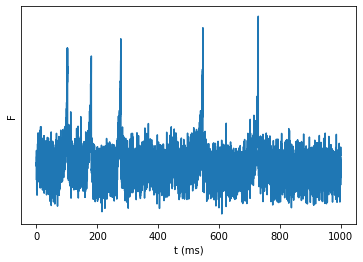

In [ ]:
SNR = 10
spike_height = v_peak - v_r

s_noise = spike_height / SNR
noise = np.random.randn(N)*s_noise
fig, ax = plot_signal(v+noise, 'F')
ax.set_yticks([]);